In [56]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import chess_cv.utils as utils
from sklearn import linear_model
%matplotlib inline

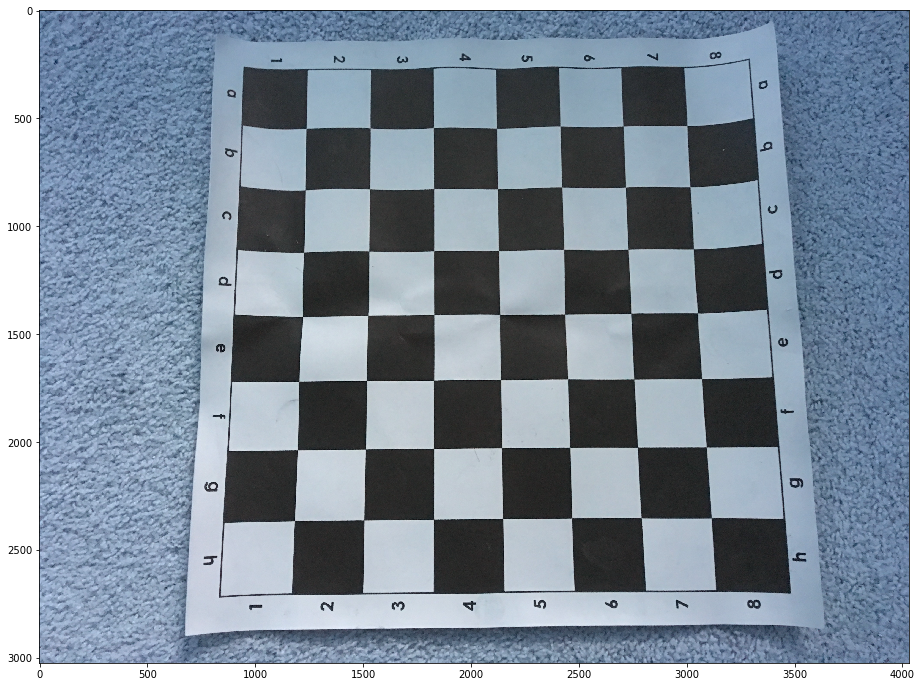

In [171]:
img_bgr = cv2.imread('data/IMG_0649.JPG') # works
#img_bgr = cv2.imread('data/IMG_0650.JPG') # works

#img_bgr = cv2.imread('data/IMG_0648.JPG') # works with sqrt y calc and bad line filtering
#img_bgr = cv2.imread('data/IMG_0651.JPG') # works with sqrt y calc and bad line filtering

def rotateImage(image, angle):
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
    return result
img_bgr = rotateImage(img_bgr, 0)
utils.imshow_lg(plt, img_bgr)

In [172]:
img_gray = utils.bgr2gray(img_bgr)
rows, cols = img_gray.shape
d_img = cv2.pyrDown(img_gray, dstsize=(cols // 2, rows // 2))
rows, cols = d_img.shape
d2_img = cv2.pyrDown(d_img, dstsize=(cols // 2, rows // 2))

In [173]:
print(d2_img.shape, img_gray.shape)

(756, 1008) (3024, 4032)


In [174]:
ret, cc = cv2.findChessboardCorners(d2_img, (7,7))

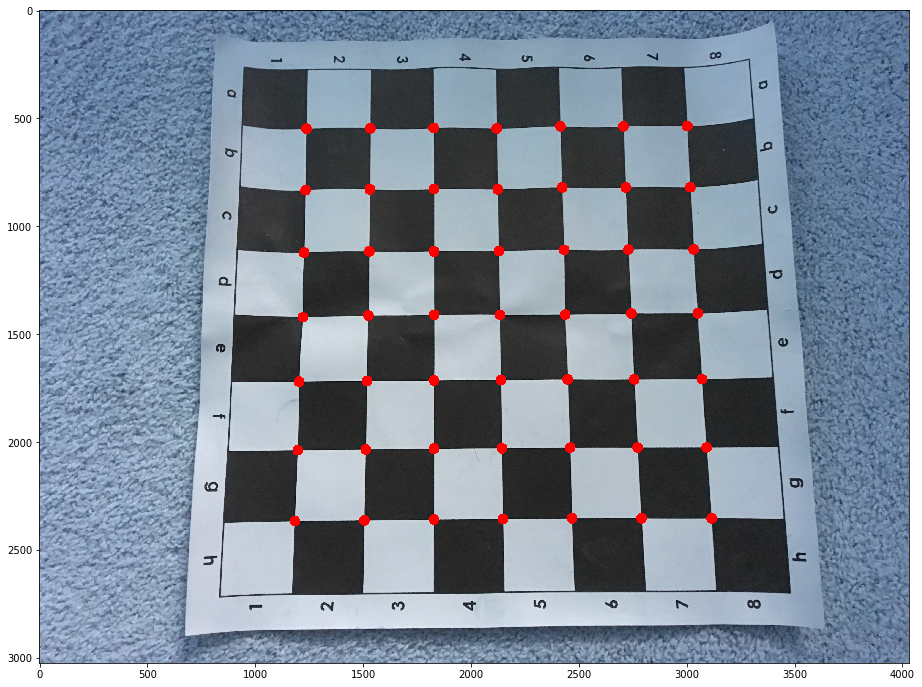

In [175]:
img = np.copy(img_bgr)

utils.draw_points(img, cc[:, 0] * 4, color=(255, 0, 0))
utils.imshow_lg(plt, img)

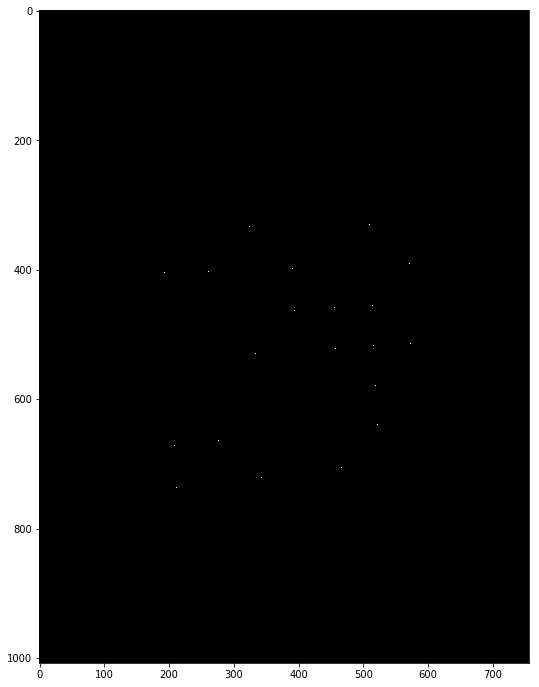

In [62]:
b_img = np.zeros_like(d2_img)
for i in np.rint(cc[:,0]).astype(np.int16):
    x, y = i
    b_img[y, x] = 1

utils.imshow_lg(plt, b_img, cmap='gray')

In [63]:
rho_accuracy = 10

In [64]:
def merge_lines_threshold(lines, intercept, threshold, vert=True):
    sint, cost = np.sin(lines[:, 0, 1]), np.cos(lines[:, 0, 1])
    if vert:
        b = (lines[:, 0, 0] - intercept * sint) / cost
    else:
        b = (lines[:, 0, 0] - intercept * cost) / sint
    b = b.reshape(b.shape[0], 1)
    
    # TODO we don't even consider m. This should be removed.
    m = -sint / cost
    m = m.reshape(m.shape[0], 1)
    
    points = np.hstack((b, m))
    sorted_indices = points[:, 0].argsort()
    sorted_lines = points[sorted_indices]
    sorted_houghlines = lines[sorted_indices]

    merged_lines = np.empty((0,2), np.float32)
    curr_line = np.empty((0,2), np.float32)
    curr_hline = np.empty((0,2), np.float32)
    for line, hline in zip(sorted_lines, sorted_houghlines):
        # what this condition looked like before:
        # if not (curr_line.shape[0] == 0 or line[1] > curr_line[-1][1]):
        # this was checking when the slope of the lines stopped monotonically increasing
        # HOWEVER, lines on a chessboard shot at an angle are all monotonically increasing
        # (when sorted, that is)
        if not (curr_line.shape[0] == 0 or line[0] - curr_line[-1][0] < threshold):
            merged_lines = np.append(merged_lines, [np.mean(curr_hline, axis=0)], axis=0)
            curr_line = np.empty((0,2), np.float32)
            curr_hline = np.empty((0,2), np.float32)
        curr_line = np.append(curr_line, [line], axis=0)
        if hline[0][0] < 0:
            curr_hline = np.append(curr_hline, [np.array([-hline[0, 0], hline[0, 1] - np.pi])], axis=0)
        else:
            curr_hline = np.append(curr_hline, [hline[0]], axis=0)

    merged_lines = np.append(merged_lines, [np.mean(curr_hline, axis=0)], axis=0)
    merged_lines = merged_lines.reshape(merged_lines.shape[0], 1, 2)
    
    return merged_lines

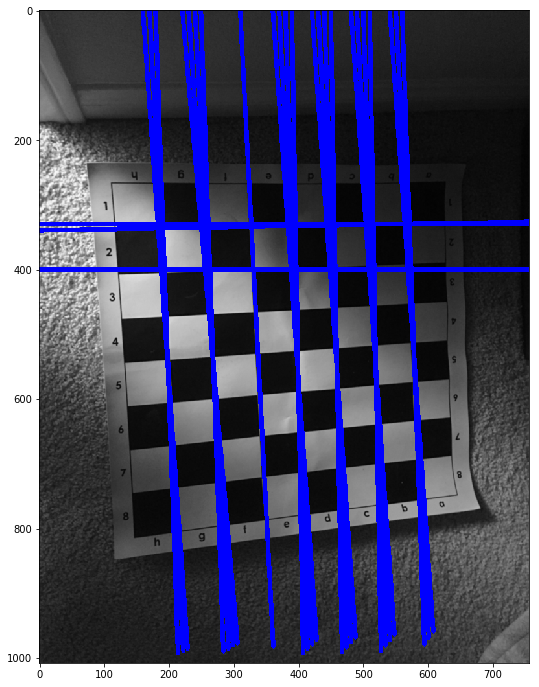

In [65]:
tmp_img = np.copy(b_img)
# TODO: do this until we have enough hough lines to work with
# need at least 4 of each
houghlines = cv2.HoughLines(tmp_img, rho_accuracy, np.pi/180,4)

tmp_img = np.copy(utils.gray2rgb(d2_img))
# added vert_low and vert_high for IMG_0648.JPG
horiz, vert = utils.filter_houghlines(houghlines, horiz_low=(88, 265), horiz_high=(92, 276), vert_low=(-1, 150), vert_high=(30,180))


utils.draw_houghlines(tmp_img, horiz)
utils.draw_houghlines(tmp_img, vert)
utils.imshow_lg(plt, tmp_img)

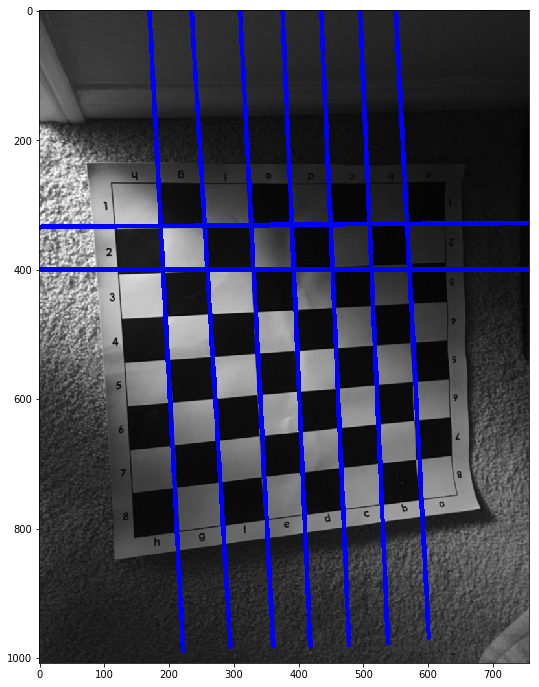

In [66]:
new_img = np.copy(utils.gray2rgb(d2_img))

#merged_lines_horiz = utils.merge_lines(horiz, rho_accuracy)
#merged_lines_vert = utils.merge_lines(vert, rho_accuracy)
#utils.draw_houghlines(new_img, merged_lines_horiz)
#utils.draw_houghlines(new_img, merged_lines_vert)
#utils.imshow_lg(plt, new_img)
width = new_img.shape[0]
height = new_img.shape[1]

merged_vert_lines = merge_lines_threshold(vert, height, 45)
merged_horiz_lines = merge_lines_threshold(horiz, 0, 11, False)

utils.draw_houghlines(new_img, merged_vert_lines)
utils.draw_houghlines(new_img, merged_horiz_lines)
utils.imshow_lg(plt, new_img)

In [67]:
#mlv = merged_lines_vert
#mlh = merged_lines_horiz

mlv = merged_vert_lines
mlh = merged_horiz_lines
detector = utils.detect_bad_line(mlh, mlv, cc, min_distance=9)
mlv = mlv[np.sum(detector, axis=0) >= mlh.shape[0] - 1]
mlh = mlh[np.sum(detector, axis=1) >= mlv.shape[0] - 1]
x = utils.x_intersect(mlv, height)
y = utils.y_intersect(mlh)

In [68]:
alg = linear_model.LinearRegression
vert_assignments, horiz_assignments = utils.get_best_assignment(x, alg=alg), utils.get_best_assignment(np.sqrt(y), alg=alg)
print(vert_assignments, horiz_assignments)

(1, 2, 3, 4, 5, 6, 7) (1, 6)


In [69]:
h = utils.get_best_bih(mlh, mlv, horiz_assignments, vert_assignments, cc, min_distance=11)

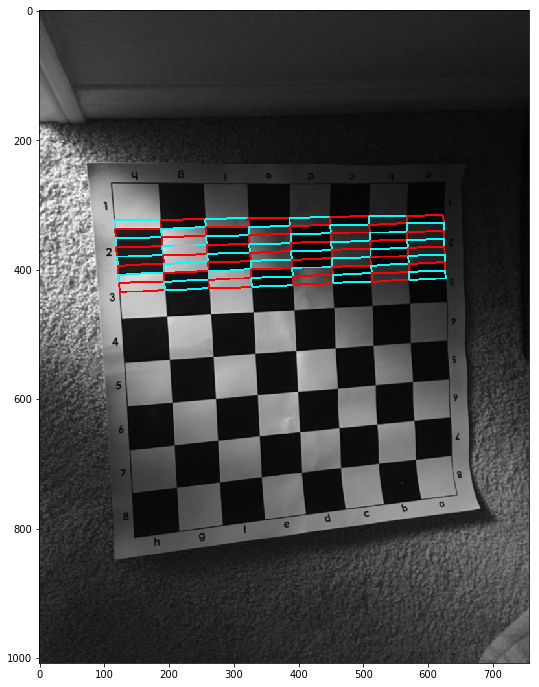

In [70]:
bih_img = np.copy(utils.gray2rgb(d2_img))

ind2pt = np.linalg.inv(h)
blue = (0,255,255)
red = (255,0,0)
color = blue
for i in range(0,8):
    if color == blue:
        color = red
    else:
        color = blue
    for j in range(0,8):
        if color == blue:
            color = red
        else:
            color = blue
        points = np.array([utils.get_point(i,j,ind2pt),
                           utils.get_point(i,j+1,ind2pt),
                           utils.get_point(i+1,j+1,ind2pt),
                           utils.get_point(i+1,j,ind2pt)])
        cv2.polylines(bih_img, np.int32([points]), 1, color, thickness=2)
        
utils.imshow_lg(plt, bih_img)